In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
!pip install tweet-preprocessor
import preprocessor as prep
import re
import string
from keras.preprocessing.text import text_to_word_sequence

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize.casual import TweetTokenizer
tokenizer = TweetTokenizer()
from bs4 import BeautifulSoup




/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
def preprocess_df(in_df):

  prep.set_options(prep.OPT.URL, prep.OPT.MENTION,prep.OPT.EMOJI)


  stopset = set(stopwords.words("english"))
  filter_word = lambda w:w not in stopset

  for index , row in in_df.iterrows():

    temp_text = row['text']

    temp_text = prep.clean(row['text'])

    temp_text = temp_text.lower()

    temp_text = BeautifulSoup(temp_text, 'lxml').get_text()


    temp_text = tokenizer.tokenize(temp_text)
    temp_text = list(filter(filter_word,temp_text))
    temp_text = ' '.join(temp_text)

    temp_text = temp_text.translate(str.maketrans('', '', string.punctuation))

    temp_text = re.sub('[\d|\@|\$|\%|\&|\*]+','',temp_text)

    in_df.loc[index,'text'] = temp_text
    
  return in_df  

#Balanced Data

In [3]:
df_1 = pd.read_csv("/content/drive/MyDrive/nndl/mp2/sentiment_final.csv")
df_1.sentiment[df_1.sentiment == 'Positive'] = 1
df_1.sentiment[df_1.sentiment == 'Negative'] = 0

ros = RandomOverSampler(random_state=777)
df_balanced = pd.DataFrame(df_1.text, columns=['text'])
X_ROS, y_ROS = ros.fit_sample(df_balanced, df_1.sentiment)
df_balanced = pd.DataFrame(X_ROS,columns=['text'])
df_balanced['sentiment'] = y_ROS

df = preprocess_df(df_balanced.copy())

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:93: UserWarning: 'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got unknown instead.
  TARGET_KIND, type_of_target(y)))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#Text to Sequence

In [4]:
total_words = []
for i , r in df.iterrows():
  tweet_words = text_to_word_sequence(r.text, filters='', lower=True, split=' ')
  total_words +=tweet_words
vocab = set(total_words)
word_to_index ={}
j=0
for word in vocab:
  word_to_index[word]=j
  j +=1


In [5]:
for i , r in df.iterrows():
  tweet_words = text_to_word_sequence(r.text, filters='', lower=True, split=' ')
  df.text.iloc[i]=[word_to_index.get(key) for key in tweet_words]

In [6]:
df.head()

,text,sentiment
0,"[8426, 4314, 4617, 7228, 2829, 3489, 3711, 405...",1
1,"[8426, 2724, 4146, 2152, 3316, 2185, 7956, 101...",1
2,"[8426, 7228, 69, 3256, 7292, 5090, 3454, 7260,...",1
3,"[8426, 7388, 4894, 2988, 1419, 8236, 9758, 750...",1
4,"[8426, 9390, 2189, 1105, 8789, 7726, 5115, 722...",0


In [8]:
len(df[df.sentiment==0])

8493

In [54]:
len(df[df.sentiment==1])


8493

#Choose Batch Size

In [25]:
for batch_size in [4,8,16,32,64,128]:
  max_features = len(word_to_index)

  maxlen = df.text.map(lambda x:len(x)).max()


  x_train, x_test, y_train, y_test = train_test_split(df['text'], 
                                                      df['sentiment'], 
                                                      random_state=1375, 
                                                      test_size=0.2, 
                                                      stratify=df['sentiment'])
  
  print('Pad sequences (samples x time)')
  x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
  x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

  print('x_train shape:', x_train.shape)
  print('x_test shape:', x_test.shape)


  y_train = np.array(y_train)
  y_test = np.array(y_test)

  y_train = y_train.astype('int32')
  y_test = y_test.astype('int32')

  model = Sequential()
  model.add(Embedding(max_features, maxlen, input_length=maxlen))
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))

  model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

  print('Train...')
  hist = model.fit(x_train, y_train,batch_size=batch_size,epochs=10,validation_split=0.125)


  true_label = y_test
  predicted_label = model.predict_classes(x_test)
  predicted_label = predicted_label.reshape(1,len(predicted_label))
  predicted_label = predicted_label[0]

  accuracy = accuracy_score(true_label, predicted_label)

  print('Accuracy = ',batch_size,'\t',round(accuracy,5),'\n')

Pad sequences (samples x time)
x_train shape: (13588, 25)
x_test shape: (3398, 25)
Train...
Epoch 1/10
2973/2973 [==============================] - 64s 20ms/step - loss: 0.5237 - accuracy: 0.7154 - val_loss: 0.3423 - val_accuracy: 0.8587
Epoch 2/10
2973/2973 [==============================] - 58s 20ms/step - loss: 0.2281 - accuracy: 0.9146 - val_loss: 0.2762 - val_accuracy: 0.8917
Epoch 3/10
2973/2973 [==============================] - 58s 20ms/step - loss: 0.1520 - accuracy: 0.9411 - val_loss: 0.2641 - val_accuracy: 0.8994
Epoch 4/10
2973/2973 [==============================] - 58s 19ms/step - loss: 0.1175 - accuracy: 0.9547 - val_loss: 0.2985 - val_accuracy: 0.9011
Epoch 5/10
2973/2973 [==============================] - 58s 19ms/step - loss: 0.1038 - accuracy: 0.9582 - val_loss: 0.2954 - val_accuracy: 0.9082
Epoch 6/10
2973/2973 [==============================] - 58s 20ms/step - loss: 0.0922 - accuracy: 0.9624 - val_loss: 0.3340 - val_accuracy: 0.9088
Epoch 7/10
2973/2973 [==========

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy =  4 	 0.92319 

Pad sequences (samples x time)
x_train shape: (13588, 25)
x_test shape: (3398, 25)
Train...
Epoch 1/10
1487/1487 [==============================] - 35s 21ms/step - loss: 0.5321 - accuracy: 0.7041 - val_loss: 0.3237 - val_accuracy: 0.8546
Epoch 2/10
1487/1487 [==============================] - 29s 20ms/step - loss: 0.2324 - accuracy: 0.9116 - val_loss: 0.2928 - val_accuracy: 0.8876
Epoch 3/10
1487/1487 [==============================] - 29s 20ms/step - loss: 0.1631 - accuracy: 0.9385 - val_loss: 0.3499 - val_accuracy: 0.8923
Epoch 4/10
1487/1487 [==============================] - 30s 20ms/step - loss: 0.1196 - accuracy: 0.9524 - val_loss: 0.2763 - val_accuracy: 0.9017
Epoch 5/10
1487/1487 [==============================] - 30s 20ms/step - loss: 0.1033 - accuracy: 0.9593 - val_loss: 0.4002 - val_accuracy: 0.8941
Epoch 6/10
1487/1487 [==============================] - 29s 20ms/step - loss: 0.0932 - accuracy: 0.9585 - val_loss: 0.3417 - val_accuracy: 0.9082
Epoch 

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy =  8 	 0.91789 

Pad sequences (samples x time)
x_train shape: (13588, 25)
x_test shape: (3398, 25)
Train...
Epoch 1/10
744/744 [==============================] - 21s 21ms/step - loss: 0.5549 - accuracy: 0.6925 - val_loss: 0.3327 - val_accuracy: 0.8634
Epoch 2/10
744/744 [==============================] - 15s 20ms/step - loss: 0.2405 - accuracy: 0.9101 - val_loss: 0.2757 - val_accuracy: 0.8870
Epoch 3/10
744/744 [==============================] - 15s 20ms/step - loss: 0.1632 - accuracy: 0.9383 - val_loss: 0.2950 - val_accuracy: 0.8982
Epoch 4/10
744/744 [==============================] - 15s 20ms/step - loss: 0.1281 - accuracy: 0.9526 - val_loss: 0.3510 - val_accuracy: 0.8935
Epoch 5/10
744/744 [==============================] - 15s 20ms/step - loss: 0.1059 - accuracy: 0.9568 - val_loss: 0.3147 - val_accuracy: 0.8929
Epoch 6/10
744/744 [==============================] - 15s 20ms/step - loss: 0.0871 - accuracy: 0.9639 - val_loss: 0.2890 - val_accuracy: 0.9088
Epoch 7/10
744/744

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy =  16 	 0.91436 

Pad sequences (samples x time)
x_train shape: (13588, 25)
x_test shape: (3398, 25)
Train...
Epoch 1/10
372/372 [==============================] - 13s 24ms/step - loss: 0.5817 - accuracy: 0.6732 - val_loss: 0.3331 - val_accuracy: 0.8511
Epoch 2/10
372/372 [==============================] - 8s 20ms/step - loss: 0.2436 - accuracy: 0.9070 - val_loss: 0.2823 - val_accuracy: 0.8893
Epoch 3/10
372/372 [==============================] - 7s 20ms/step - loss: 0.1570 - accuracy: 0.9445 - val_loss: 0.2619 - val_accuracy: 0.8999
Epoch 4/10
372/372 [==============================] - 7s 20ms/step - loss: 0.1352 - accuracy: 0.9502 - val_loss: 0.2797 - val_accuracy: 0.8911
Epoch 5/10
372/372 [==============================] - 8s 20ms/step - loss: 0.1208 - accuracy: 0.9553 - val_loss: 0.2795 - val_accuracy: 0.8994
Epoch 6/10
372/372 [==============================] - 8s 20ms/step - loss: 0.0988 - accuracy: 0.9611 - val_loss: 0.3190 - val_accuracy: 0.8988
Epoch 7/10
372/372 [==

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy =  32 	 0.89994 

Pad sequences (samples x time)
x_train shape: (13588, 25)
x_test shape: (3398, 25)
Train...
Epoch 1/10
186/186 [==============================] - 9s 28ms/step - loss: 0.6021 - accuracy: 0.6397 - val_loss: 0.3378 - val_accuracy: 0.8611
Epoch 2/10
186/186 [==============================] - 4s 21ms/step - loss: 0.2479 - accuracy: 0.9105 - val_loss: 0.2855 - val_accuracy: 0.8946
Epoch 3/10
186/186 [==============================] - 4s 21ms/step - loss: 0.1729 - accuracy: 0.9381 - val_loss: 0.3241 - val_accuracy: 0.8970
Epoch 4/10
186/186 [==============================] - 4s 21ms/step - loss: 0.1401 - accuracy: 0.9495 - val_loss: 0.2893 - val_accuracy: 0.9017
Epoch 5/10
186/186 [==============================] - 4s 22ms/step - loss: 0.1144 - accuracy: 0.9591 - val_loss: 0.3147 - val_accuracy: 0.8823
Epoch 6/10
186/186 [==============================] - 4s 21ms/step - loss: 0.1117 - accuracy: 0.9598 - val_loss: 0.3147 - val_accuracy: 0.8999
Epoch 7/10
186/186 [===

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy =  64 	 0.91289 

Pad sequences (samples x time)
x_train shape: (13588, 25)
x_test shape: (3398, 25)
Train...
Epoch 1/10
93/93 [==============================] - 8s 35ms/step - loss: 0.6591 - accuracy: 0.6012 - val_loss: 0.4079 - val_accuracy: 0.8164
Epoch 2/10
93/93 [==============================] - 2s 22ms/step - loss: 0.3051 - accuracy: 0.8739 - val_loss: 0.2889 - val_accuracy: 0.8864
Epoch 3/10
93/93 [==============================] - 2s 23ms/step - loss: 0.1818 - accuracy: 0.9390 - val_loss: 0.2712 - val_accuracy: 0.9005
Epoch 4/10
93/93 [==============================] - 2s 22ms/step - loss: 0.1335 - accuracy: 0.9520 - val_loss: 0.2776 - val_accuracy: 0.9035
Epoch 5/10
93/93 [==============================] - 2s 22ms/step - loss: 0.1124 - accuracy: 0.9604 - val_loss: 0.2656 - val_accuracy: 0.9017
Epoch 6/10
93/93 [==============================] - 2s 23ms/step - loss: 0.1123 - accuracy: 0.9571 - val_loss: 0.3353 - val_accuracy: 0.9005
Epoch 7/10
93/93 [=================

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy =  128 	 0.88935 



#Train model

In [26]:
max_features = len(word_to_index)

maxlen = df.text.map(lambda x:len(x)).max()
batch_size = 4


x_train, x_test, y_train, y_test = train_test_split(df['text'], 
                                                    df['sentiment'], 
                                                    random_state=1375, 
                                                    test_size=0.2, 
                                                    stratify=df['sentiment'])

In [27]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')


Pad sequences (samples x time)
x_train shape: (13588, 25)
x_test shape: (3398, 25)


In [28]:
model = Sequential()
model.add(Embedding(max_features, maxlen, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
hist = model.fit(x_train, y_train,batch_size=batch_size,epochs=10,validation_split=0.125)

Train...
Epoch 1/10
2973/2973 [==============================] - 63s 20ms/step - loss: 0.5238 - accuracy: 0.7234 - val_loss: 0.3230 - val_accuracy: 0.8629
Epoch 2/10
2973/2973 [==============================] - 58s 19ms/step - loss: 0.2382 - accuracy: 0.9101 - val_loss: 0.2584 - val_accuracy: 0.9023
Epoch 3/10
2973/2973 [==============================] - 58s 19ms/step - loss: 0.1578 - accuracy: 0.9373 - val_loss: 0.2575 - val_accuracy: 0.9029
Epoch 4/10
2973/2973 [==============================] - 59s 20ms/step - loss: 0.1039 - accuracy: 0.9604 - val_loss: 0.3031 - val_accuracy: 0.9005
Epoch 5/10
2973/2973 [==============================] - 58s 19ms/step - loss: 0.1023 - accuracy: 0.9607 - val_loss: 0.2742 - val_accuracy: 0.9105
Epoch 6/10
2973/2973 [==============================] - 58s 19ms/step - loss: 0.0828 - accuracy: 0.9664 - val_loss: 0.2961 - val_accuracy: 0.9147
Epoch 7/10
2973/2973 [==============================] - 58s 19ms/step - loss: 0.0856 - accuracy: 0.9658 - val_loss:

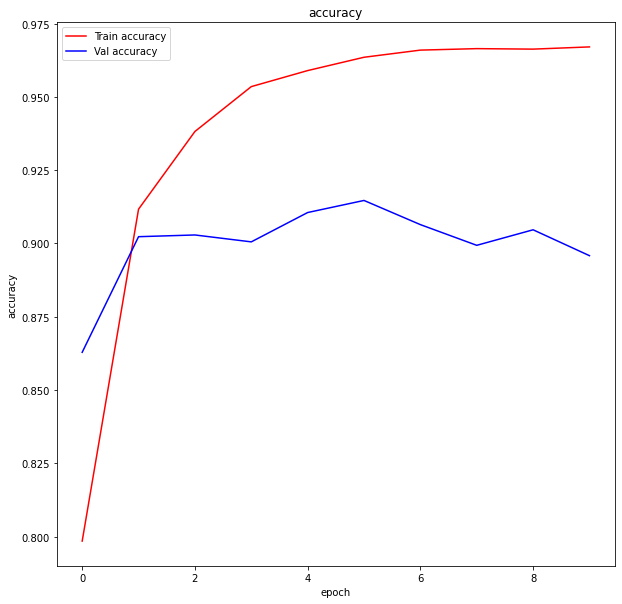

In [32]:
plt.figure(figsize=(10,10))

plt.plot(hist.history['accuracy'],color='r')
plt.plot(hist.history['val_accuracy'],color='b')
plt.legend(['Train accuracy','Val accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

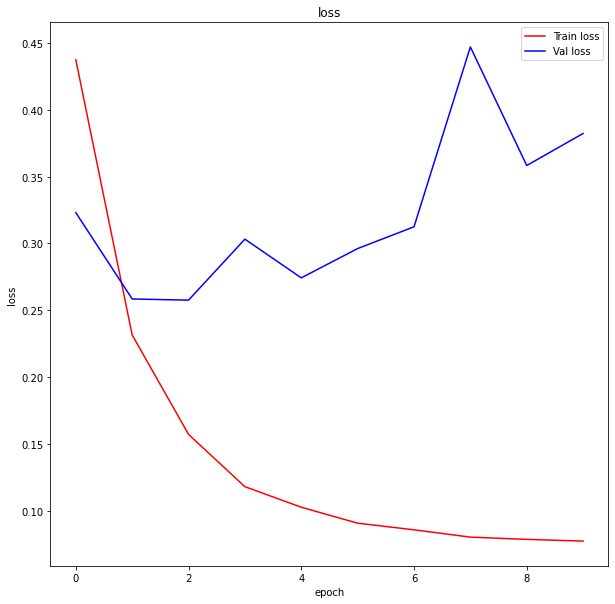

In [33]:
plt.figure(figsize=(10,10))

plt.plot(hist.history['loss'],color='r')
plt.plot(hist.history['val_loss'],color='b')
plt.legend(['Train loss','Val loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#Evaluate

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Precision =  0.91454 

Recall =  0.90759 

F1 =  0.9072 

Accuracy =  0.90759 



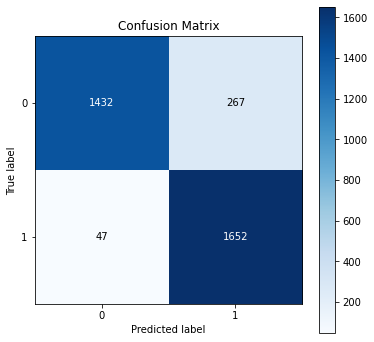

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score,confusion_matrix
!pip install -q scikit-plot
import scikitplot as skplt

true_label = y_test
predicted_label = model.predict_classes(x_test)
predicted_label = predicted_label.reshape(1,len(predicted_label))
predicted_label = predicted_label[0]
skplt.metrics.plot_confusion_matrix(true_label,predicted_label,title="Confusion Matrix",figsize=(6,6))

precision = precision_score(true_label, predicted_label, average='macro')
recall = recall_score(true_label, predicted_label, average='macro')
f1 = f1_score(true_label, predicted_label,average='macro')
accuracy = accuracy_score(true_label, predicted_label)

print('Precision = ',round(precision,5),'\n')
print('Recall = ',round(recall,5),'\n')
print('F1 = ',round(f1,5),'\n')
print('Accuracy = ',round(accuracy,5),'\n')